### Importar librerías

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
#from scipy import sparse
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

### Carga de los datos

In [2]:
data = pd.read_csv("SMSSpamCollection.csv", header = -1,names=["Label", "Message"])
print(data.head())

  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


### Exploración de los datos

In [3]:
print("Número de mensajes spam y ham: ")
print(data["Label"].value_counts()) # Output how many messages are spam or ham

Número de mensajes spam y ham: 
ham     4827
spam     747
Name: Label, dtype: int64


In [4]:
def generatingWordCloud(dataFrame):
    comment_words = ' '
    stopwords = set(STOPWORDS)
    #stopWords = set(stopwords.words('spanish'))
    
    # iterate through the csv file
    for val in dataFrame.Message:
        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        for words in tokens:
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width=800, height=800,background_color='white',stopwords=stopwords, min_font_size=10).generate(comment_words)

    # plot the WordCloud image
    %matplotlib inline
    plt.figure(figsize=(6, 6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    #Guardar el wordcloud como imagen png
    #wordcloud.to_file("first_review.png")


Wordcloud de mensajes importantes


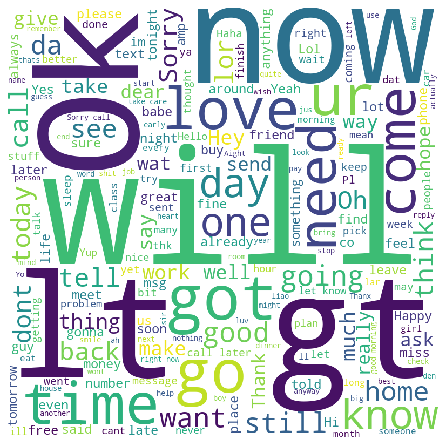

In [5]:
print("\nWordcloud de mensajes importantes")
generatingWordCloud(data.loc[data['Label'] == 'ham'])


Wordcloud de spam


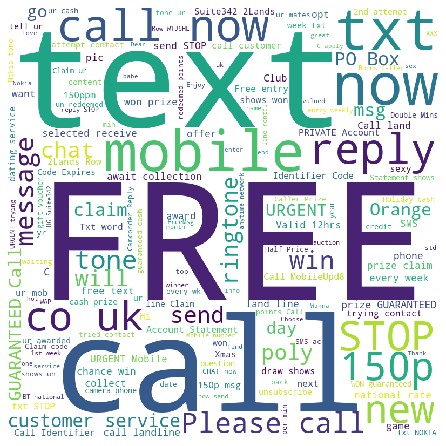

In [6]:
print("\nWordcloud de spam")
generatingWordCloud(data.loc[data['Label'] == 'spam'])

### Preprocesamiento de los datos

In [7]:
data['Message'] = data.Message.map(lambda x: x.lower())  #Convierte todo a minúsculas
data['Message'] = data.Message.str.replace('[^\w\s]','') #Elimina signos de puntuación
data['Message'] = data.Message.str.replace('[0-9]','') #Eliminar números
#pattern = '[0-9]'
#data['Message'] = [re.sub(pattern, '', i) for i in data['Message']] #Elimina números 
data['Message'] = data['Message'].apply(nltk.word_tokenize)  #Tokenización
nltk_words = list(stopwords.words('english')) #About 150 stopwords
data['Message'] = [w for w in data['Message'] if not w in nltk_words]  #Elimina Stop words

print(data.head())

  Label                                            Message
0   ham  [go, until, jurong, point, crazy, available, o...
1   ham                     [ok, lar, joking, wif, u, oni]
2  spam  [free, entry, in, a, wkly, comp, to, win, fa, ...
3   ham  [u, dun, say, so, early, hor, u, c, already, t...
4   ham  [nah, i, dont, think, he, goes, to, usf, he, l...


### Preparación de los datos

In [8]:
data['Message'] = data['Message'].apply(lambda x: ' '.join(x)) # This converts the list of words into space-separated strings
count_vect = CountVectorizer()
bagofWords = count_vect.fit_transform(data['Message'])

In [11]:
suma = bagofWords.sum(axis=0) 

In [12]:
print(suma)

[[2 1 3 ... 1 1 3]]


### Reducción de dimensionalidad

In [13]:
bagofWords = bagofWords.toarray()

In [14]:
size = bagofWords.shape
print(size)

(5574, 8605)


In [15]:
d = []
for i in range(0,size[1]):
    if suma[0,i] < 5:
        d.append(i)

In [16]:
bagofWords = np.delete(bagofWords,d,1)
print(bagofWords.shape)
bagofWords = csr_matrix(bagofWords)

(5574, 1739)


### Separación del data set en datos de entrenamiento y de prueba 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(bagofWords, data['Label'], test_size=0.2, random_state=69)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4459, 1739)
(4459,)
(1115, 1739)
(1115,)


### Entrenamiento del modelo con los datos

In [17]:
model = MultinomialNB(alpha=1.0).fit(X_train, y_train)
y_pred = model.predict(X_test)

### Validando el modelo

In [18]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print('Precisión del modelo(entrenamiento): ' + str(train_accuracy))
print('Precisión del modelo(prueba): ' + str(test_accuracy))
print('')
print('Matriz de confusión')
print(pd.crosstab(y_test, y_pred, rownames = ['True'], colnames = ['Predicted'], margins = True))
print('')
print(classification_report(y_test,y_pred))

Precisión del modelo(entrenamiento): 0.9860955371159453
Precisión del modelo(prueba): 0.97847533632287

Matriz de confusión
Predicted  ham  spam   All
True                      
ham        955     8   963
spam        16   136   152
All        971   144  1115

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       963
        spam       0.94      0.89      0.92       152

   micro avg       0.98      0.98      0.98      1115
   macro avg       0.96      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

